In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Dataset_modified_pom.csv')

In [3]:
df = df.drop(['Product Availibility index','City'],axis=1)

In [4]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

<ipython-input-5-17a4e23d5e1b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1932, number of used features: 3
[LightGBM] [Info] Start training from score 189.488219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1932, number of used features: 3
[LightGBM] [Info] Start training from score 186.147873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1932

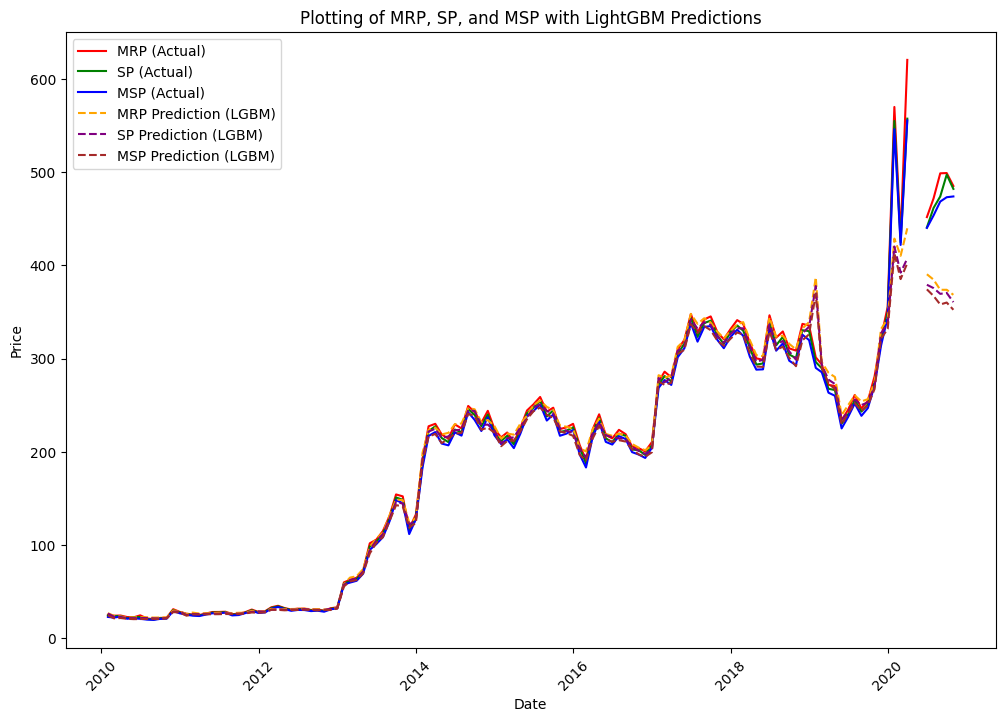

In [5]:
#Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract date-related features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Features (X) and target variables (y)
X = df[['Year', 'Month', 'Day']]
y_mrp = df['MRP']
y_sp = df['SP']
y_msp = df['MSP']

# Split the data into training and testing sets
X_train, X_test, y_mrp_train, y_mrp_test, y_sp_train, y_sp_test, y_msp_train, y_msp_test = train_test_split(
    X, y_mrp, y_sp, y_msp, test_size=0.2, random_state=42
)

# Create LightGBM regressors for each target variable
lgbm_regressor_mrp = LGBMRegressor(n_estimators=100, random_state=42)
lgbm_regressor_sp = LGBMRegressor(n_estimators=100, random_state=42)
lgbm_regressor_msp = LGBMRegressor(n_estimators=100, random_state=42)

# Train the models
lgbm_regressor_mrp.fit(X_train, y_mrp_train)
lgbm_regressor_sp.fit(X_train, y_sp_train)
lgbm_regressor_msp.fit(X_train, y_msp_train)

# Make predictions on the test set
y_mrp_pred = lgbm_regressor_mrp.predict(X_test)
y_sp_pred = lgbm_regressor_sp.predict(X_test)
y_msp_pred = lgbm_regressor_msp.predict(X_test)

# Evaluate the models (using Mean Squared Error in this example)
mse_mrp = mean_squared_error(y_mrp_test, y_mrp_pred)
mse_sp = mean_squared_error(y_sp_test, y_sp_pred)
mse_msp = mean_squared_error(y_msp_test, y_msp_pred)

print(f"Mean Squared Error for MRP: {mse_mrp}")
print(f"Mean Squared Error for SP: {mse_sp}")
print(f"Mean Squared Error for MSP: {mse_msp}")

# Make predictions on the entire dataset for plotting
df['MRP_Pred_LGBM'] = lgbm_regressor_mrp.predict(X)
df['SP_Pred_LGBM'] = lgbm_regressor_sp.predict(X)
df['MSP_Pred_LGBM'] = lgbm_regressor_msp.predict(X)

# Downsample by aggregating into monthly averages
df_resampled = df.resample('M', on='Date').mean()

# Create the time series plot
plt.figure(figsize=(12, 8))

# Plotting the actual data
plt.plot(df_resampled['MRP'], label='MRP (Actual)', color='red')
plt.plot(df_resampled['SP'], label='SP (Actual)', color='green')
plt.plot(df_resampled['MSP'], label='MSP (Actual)', color='blue')

# Plotting the LightGBM predictions
plt.plot(df_resampled['MRP_Pred_LGBM'], label='MRP Prediction (LGBM)', linestyle='dashed', color='orange')
plt.plot(df_resampled['SP_Pred_LGBM'], label='SP Prediction (LGBM)', linestyle='dashed', color='purple')
plt.plot(df_resampled['MSP_Pred_LGBM'], label='MSP Prediction (LGBM)', linestyle='dashed', color='brown')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Plotting of MRP, SP, and MSP with LightGBM Predictions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.show()